<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/WISDM/wisdm_CBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_csv('/content/drive/MyDrive/datasets/WISDM_ar_v1.1_raw.txt', header=None, on_bad_lines='skip').dropna()

In [4]:
df.columns=['user', 'activity', 'timestamp', 'x','y','z']
df['z']=df['z'].str.replace(';','')
df=df.drop(columns=['timestamp'])
df.head()

,user,activity,x,y,z
0,33,Jogging,-0.694638,12.680544,0.50395286
1,33,Jogging,5.012288,11.264028,0.95342433
2,33,Jogging,4.903325,10.882658,-0.08172209
3,33,Jogging,-0.612916,18.496431,3.0237172
4,33,Jogging,-1.184970,12.108489,7.205164


In [5]:
df['x']=df['x'].astype(float)
df['y']=df['y'].astype(float)
df['z']=df['z'].astype(float)

In [6]:
df.isnull().sum()

,0
user,0
activity,0
x,0
y,0
z,0


In [7]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df

,user,activity,x,y,z
0,33,1,-0.694638,12.680544,0.503953
1,33,1,5.012288,11.264028,0.953424
2,33,1,4.903325,10.882658,-0.081722
3,33,1,-0.612916,18.496431,3.023717
4,33,1,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1086461,19,2,9.000000,-1.570000,1.690000
1086462,19,2,9.040000,-1.460000,1.730000
1086463,19,2,9.080000,-1.380000,1.690000
1086464,19,2,9.000000,-1.460000,1.730000


In [8]:
X=df.drop(columns=['activity'])
y=df['activity']
X

,user,x,y,z
0,33,-0.694638,12.680544,0.503953
1,33,5.012288,11.264028,0.953424
2,33,4.903325,10.882658,-0.081722
3,33,-0.612916,18.496431,3.023717
4,33,-1.184970,12.108489,7.205164
...,...,...,...,...
1086461,19,9.000000,-1.570000,1.690000
1086462,19,9.040000,-1.460000,1.730000
1086463,19,9.080000,-1.380000,1.690000
1086464,19,9.000000,-1.460000,1.730000


In [9]:
y

,activity
0,1
1,1
2,1
3,1
4,1
...,...
1086461,2
1086462,2
1086463,2
1086464,2


In [10]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [11]:
#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 28<u<=32]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

print("-----사용자 기반 데이터 분할-----")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

-----사용자 기반 데이터 분할-----
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 4명, 데이터 수: 143367
테스트용 사용자 수: 4명, 데이터 수: 120055


In [16]:

#데이터 스케일링
from sklearn.preprocessing import StandardScaler

features=['x','y','z']
scaler=StandardScaler()
#스케일링은 무조건 훈련 데이터 기준으로... 테스트 데이터 기준으로 하면=> 데이터 누수!!!!!
scaler.fit(train_df[features])

train_df[features]=scaler.transform(train_df[features])
val_df[features]=scaler.transform(val_df[features])
test_df[features]=scaler.transform(test_df[features])

In [13]:
import numpy as np
from scipy.stats import mode
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [14]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [17]:
#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [18]:
#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

print("훈련데이터:", x_train.shape, y_train_hot.shape)
print("검증데이터", x_val.shape, y_val_hot.shape)

훈련데이터: (20575, 80, 3) (20575, 6)
검증데이터 (3583, 80, 3) (3583, 6)


In [19]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1)
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1)

x_train.shape, x_val.shape

((20575, 80, 3, 1), (3583, 80, 3, 1))

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     Dense, Reshape, multiply, Concatenate, Activation, Add,
                                     BatchNormalization, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

## CBAM

### 구조

CBAM에서는 입력 Feature Map에 대해 Channel Attention과 Spatial Attention 모듈을 병렬로 배치하여 연결하였다.


반면 CBAM에서는 위의 그림과 같이 Channel Attention과 Spatial Attention 모듈을 직렬로 연결한다. 즉 입력 Feature Map에 대해 **먼저 “무엇”에 더 집중할 것인지 Channel Attention을 적용**한 후, 이렇게 나온 중간 Feature맵에 다시 **“어디”에 더 집중할 것인지 Spatial Attention을 적용**.

최종적으로 나온 Feature 맵은 **Channel Attention과 Spatial Attention이 모두 적용**되어 “무엇”과 “어디”를 볼 것인지가 모두 강조된다.

CBAM은 다음과 같은 두 단계로 작동한다.

### Channel Attention Module: 무엇을?

이 단계의 목표는 여러 채널 중에서 어떤 채널이 더 중요한지 파악하는 것이다. SENet과 유사하지만 정보를 요약하는 방식을 개선하였다.


- 핵심 개선: 정보를 압축하기 위해 Pooling 연산을 하는 건 좋은데 왜 Average Pooling만 사용할까? **Max Pooling도 같이 사용**하자!
    - **Average Pooling**: 평균값. 여기에 대략적으로 어떤 정보가 들어가있는지를 뽑아줌.
    - **Max Pooling**: Max Pooling은 가장 의미 있는 정보 외에는 무시. 따라서 가장 중요한 정보를 희석시키지 않고 추출할 수 있다.
    - 따라서 CBAM은 **Average Pooling과 Max Pooling을 병렬로 연결**하여 두 정보를 모두 사용하는 방법을 채택
- 과정
    - 정보 압축: 입력된 피처맵에 대해 **맥스 풀링과 애버리지 풀링을 각각 적용**하여 두 종류의 요약된 정보를 만든다.
    - 중요도 계산: 이 두 정보를 각각 **MLP**(이때 두 MLP는 동일한 가중치를 가진다.) 에 통과 시킨 후 나온 결과를 요소별로 더해준다.
        - 이 MLP는 SENet의 Excitation 과정에 있는 FC Layer1→ReLU→FC Layer2 구조와 동일하다.
    - 가중치 생성: 마지막으로 **시그모이드 함수**를 적용하여 **각 채널의 중요도를 나타내는 채널 가중치를 생성**.
- 결과: 생성된 채널 가중치를 원래 피처맵에 곱해주면 중요한 채널은 강조되고 덜 중요한 채널은 억제된다.

In [44]:
#ratio=채널 축소 비율, MLP를 통과 하기 전에 정보를 압축하는 병목 구조를 위해 채널 어텐션에 사용한다.
#kernel_initializer='he_normal': 가중치 초기화 방법. ReLU와 함께 사용 시 성능이 좋다.
def channel_attention(input_feature, ratio=8):
  channel_axis=-1
  channel=input_feature.shape[channel_axis]

  #MLP 레이어 공유
  shared_layer_one=Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=False, bias_initializer='zeros')
  shared_layer_two=Dense(channel, kernel_initializer='he_normal', use_bias=False, bias_initializer='zeros')

  #Global Average Pooling
  avg_pool=GlobalAveragePooling2D()(input_feature)
  avg_pool=Reshape((1,1,channel))(avg_pool)
  avg_pool=shared_layer_one(avg_pool)
  avg_pool=shared_layer_two(avg_pool)

  #Global Max Pooling: CBAM은 average pooling과 max pooling을 병렬로 연결하는 모델
  max_pool=GlobalMaxPooling2D()(input_feature)
  max_pool=Reshape((1,1,channel))(max_pool)
  max_pool=shared_layer_one(max_pool)
  max_pool=shared_layer_two(max_pool)

  #풀링 결과 합산 후 sigmoid 함수 통과=>채널 가중치
  cbam_feature=Add()([avg_pool, max_pool])
  cbam_feature=Activation('sigmoid')(cbam_feature)
  #채널 가중치를 원본 특성맵과 곱함
  return multiply([input_feature, cbam_feature])



### Spatial Attention Module: 어디를?

Spatial Attention은 Channel Attention과 달리 “어디”에 집중할 것인지를 의미한다. 채널 어텐션을 거친 피처맵을 입력으로 받아 이미지의 어떤 위치가 더 중요한지를 파악한다.

즉 입력 Feature Map에 대해 Spatial Attention 결과는 **(W*H*1) 사이즈**로 나와야 한다. CBAM에서는 Channel Attention에서와 마찬가지로 Max Pooling과 Average 연산을 사용한다.


- 과정:
    - 정보 압축: **채널 축을 따라** **맥스 풀링과 애버리지 풀링을 적용**하여 2개의 채널을 가진 특별한 피처맵을 만든다. (하나는 각 위치의 최댓값 정보, 다른 하나는 평균 정보)⇒뭔소리지
    - 중요도 계산: 이 두 피처 맵을 하나로 합친 후 7*7 크기의 컨볼루션 연산을 적용하여 공간적 관계를 학습한다.
        
        ⇒ 왜 7*7?? : 공간 주의 모듈의 목표는 이미지의 “어디를” 더 집중해서 봐야 할지를 결정하는 것이다. 이 결정을 내리려면 주변 픽셀들과의 관계, 즉 맥락을 이해해야 하기 때문에 7*7과 같이 큰 필터를 사용하여 이미지의 구조나 객체간의 관계 같은 더 넓은 맥락을 파악한다.
        
    - 가중치 생성: 시그모이드 함수를 거쳐 **각 픽셀 위치의 중요도를 나타내는 공간 가중치**를 생성한다.
- 결과: 이 공간 가중치를 입력된 피처맵에 곱해주면 중요한 위치의 정보는 강조되고 배경 등 덜 중요한 부분은 억제된다.

In [55]:
def spatial_attention(input_feature):
  kernel_size=7
  channel_axis=-1

  #채널 축에 대해 Average, Max pooling
  avg_pool=tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=channel_axis, keepdims=True))(input_feature)
  max_pool=tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=channel_axis, keepdims=True))(input_feature)

  #두 풀링 결과 결합
  concat=Concatenate(axis=channel_axis)([avg_pool, max_pool])

  #Conv 레이어, Sigmoid 통과
  cbam_feature=Conv2D(filters=1,
                      kernel_size=kernel_size,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer='he_normal',
                      use_bias=False)(concat)
  #원본 특성 맵과 곱
  return multiply([input_feature, cbam_feature])

In [56]:
def cbam_block(cbam_feature, ratio=8):
  #채널 어텐션
  cbam_feature=channel_attention(cbam_feature, ratio)
  #공간 어텐션
  cbam_feature=spatial_attention(cbam_feature)
  return cbam_feature

In [57]:
def create_cbam_model(input_shape, num_classes):
  inputs=Input(shape=input_shape)

  x=Conv2D(64, kernel_size=(3,1), padding='same', activation='relu')(inputs)
  x=BatchNormalization()(x)
  x=Conv2D(64, kernel_size=(3,1), padding='same', activation='relu')(x)
  x=BatchNormalization()(x)

  #CBAM 블록
  x=cbam_block(x)

  x=Conv2D(128, kernel_size=(3,1), padding='same', activation='relu')(x)
  x=BatchNormalization()(x)
  x=Conv2D(128, kernel_size=(3,1), padding='same', activation='relu')(x)
  x=BatchNormalization()(x)

  x=GlobalAveragePooling2D()(x)
  x=Dropout(0.4)(x)
  outputs=Dense(num_classes, activation='softmax')(x)

  model=Model(inputs=inputs, outputs=outputs)
  return model

In [58]:
input_shape = x_train.shape[1:]
num_classes = y_train_hot.shape[1]

In [59]:
model = create_cbam_model(input_shape, num_classes)

In [61]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 80, 3, 64) │        256 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 64) │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 80, 3, 64) │     12,352 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 64) │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1, 1, 64)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1, 1, 64)  │          0 │ global_max_pooli… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1, 1, 8)   │        512 │ reshape_12[0][0], │
│                     │                   │            │ reshape_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1, 1, 64)  │        512 │ dense_13[0][0],   │
│                     │                   │            │ dense_13[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 1, 1, 64)  │          0 │ dense_14[0][0],   │
│                     │                   │            │ dense_14[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1, 1, 64)  │          0 │ add_6[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 80, 3, 64) │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 80, 3, 1)  │          0 │ multiply_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 80, 3, 1)  │          0 │ multiply_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 80, 3, 2)  │          0 │ lambda_12[0][0],  │
│ (Concatenate)       │                   │            │ lambda_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 80, 3, 1)  │         98 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 90,024 (351.66 KB)

 Trainable params: 89,256 (348.66 KB)

 Non-trainable params: 768 (3.00 KB)

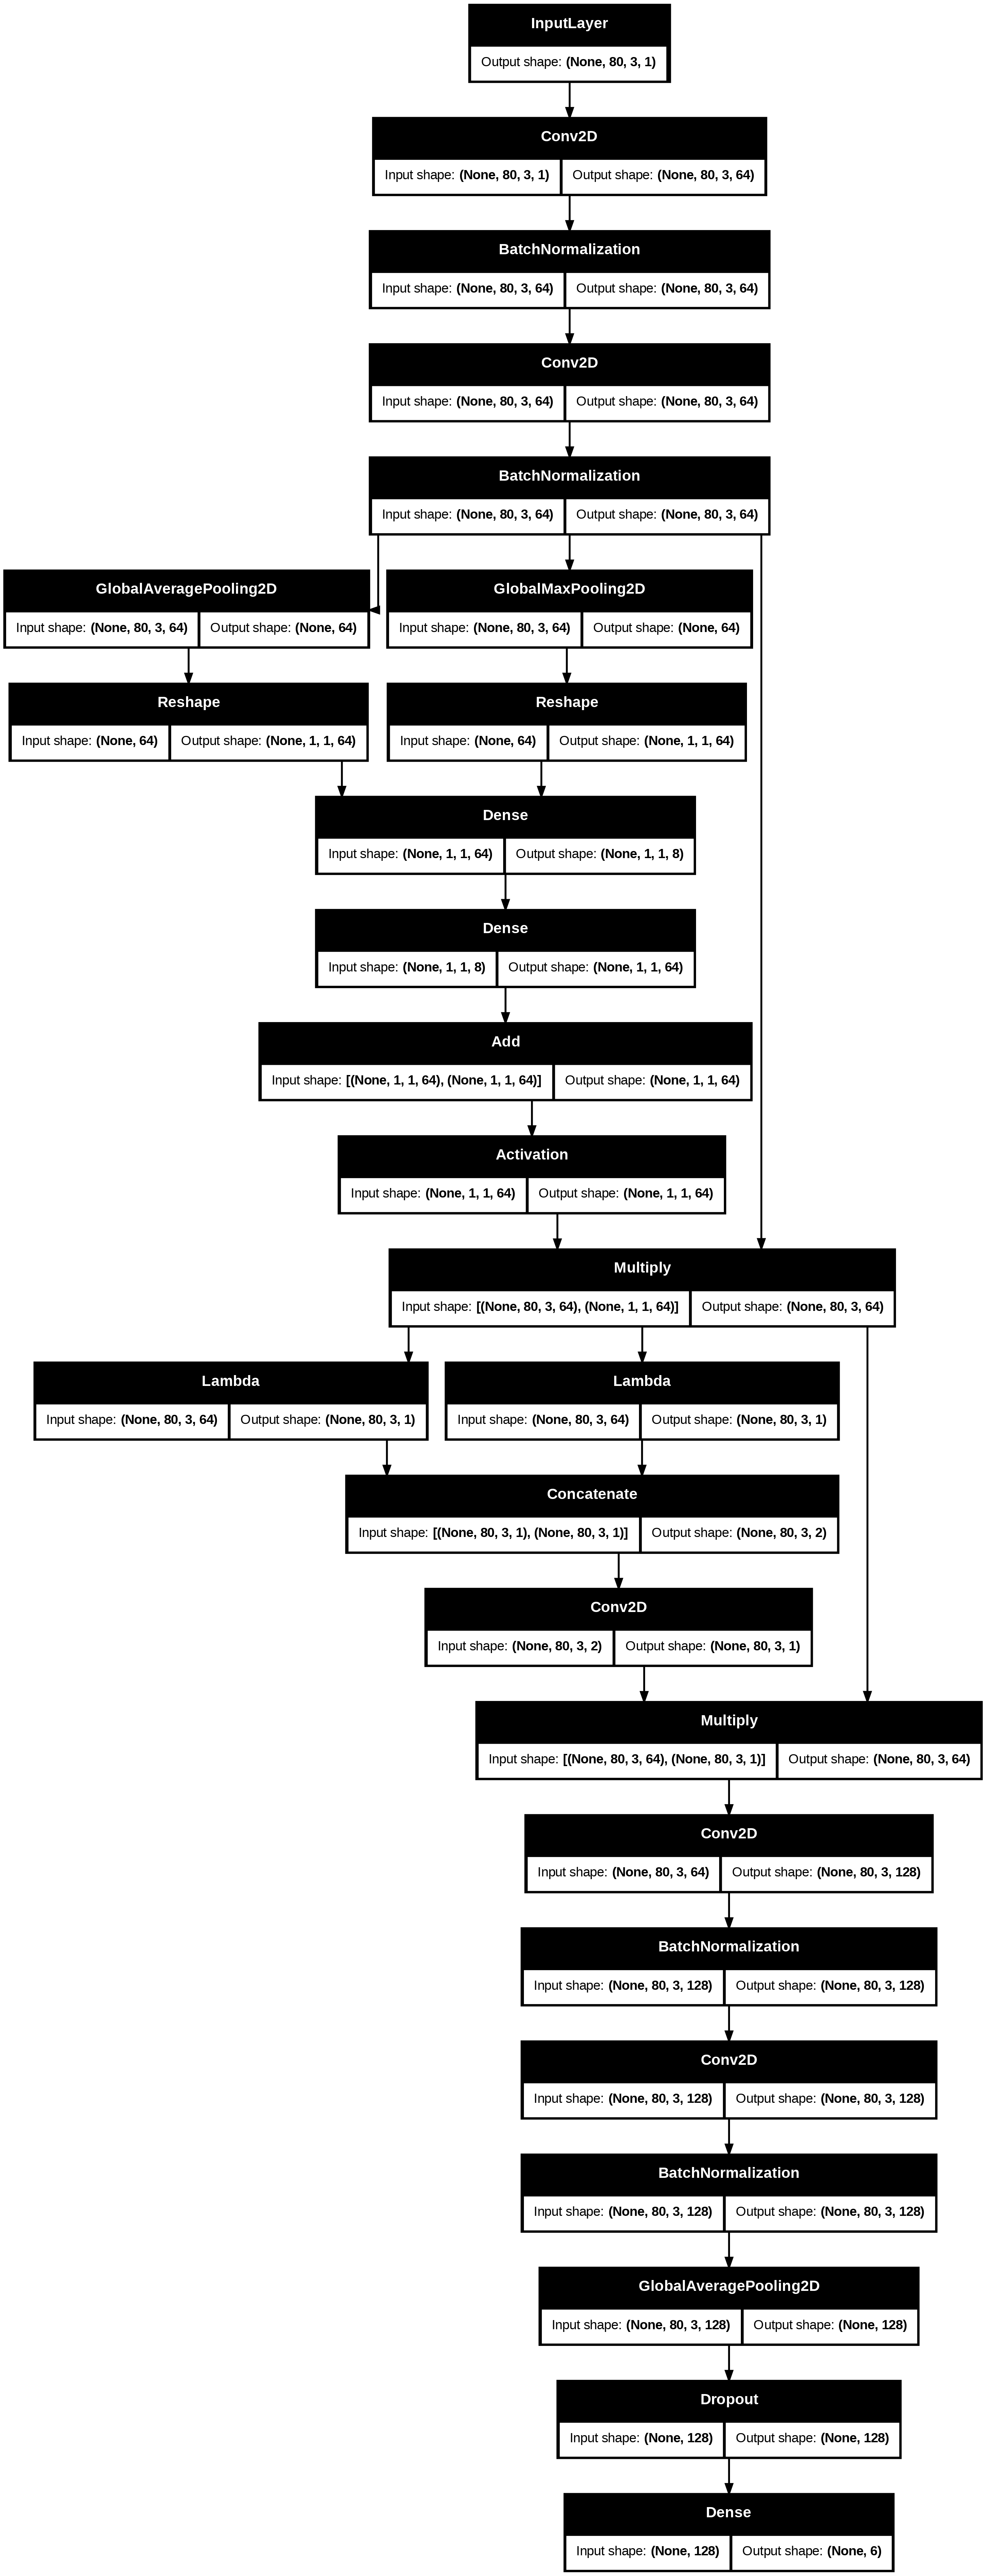

In [62]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [66]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [68]:
#모델 학습
history = model.fit(x_train, y_train_hot,
                    epochs=50,
                    batch_size=32,
                    validation_data=(x_val, y_val_hot),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 113s 175ms/step - accuracy: 0.8782 - loss: 0.3271 - val_accuracy: 0.8214 - val_loss: 0.4862 - learning_rate: 0.0010
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 134s 162ms/step - accuracy: 0.9154 - loss: 0.2353 - val_accuracy: 0.8071 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 142s 162ms/step - accuracy: 0.9370 - loss: 0.1784 - val_accuracy: 0.7823 - val_loss: 0.6462 - learning_rate: 0.0010
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 118s 183ms/step - accuracy: 0.9483 - loss: 0.1513 - val_accuracy: 0.8314 - val_loss: 0.5549 - learning_rate: 0.0010
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 127s 159ms/step - accuracy: 0.9540 - loss: 0.1296 - val_accuracy: 0.8501 - val_loss: 0.4346 - learning_rate: 0.0010
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 144s 163ms/step - accuracy: 0.9604 - loss: 0.1179 - val_accuracy: 0.8194 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 105s 163ms/step - accura

In [69]:
import matplotlib.pyplot as plt

In [71]:

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

In [72]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


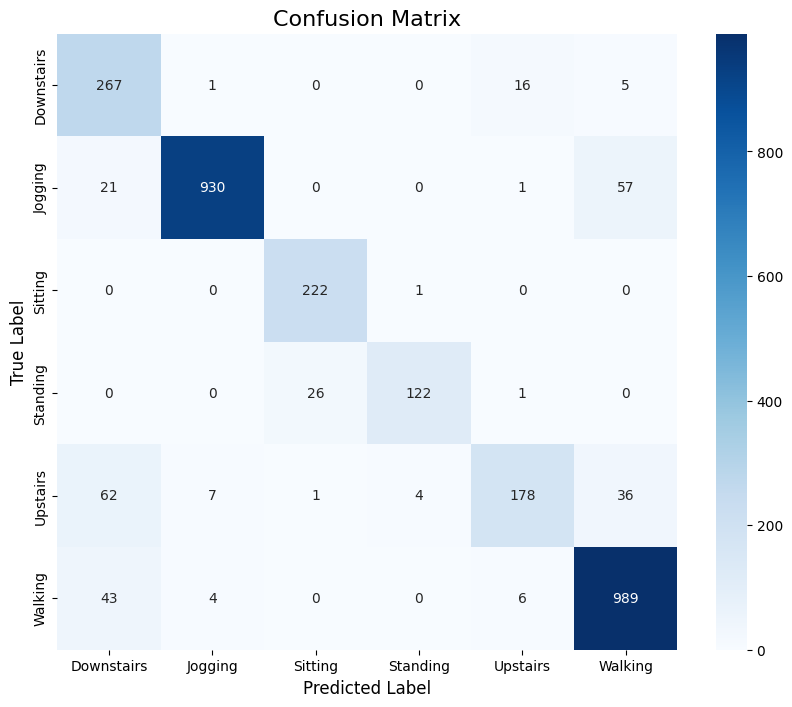

In [73]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [70]:
loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.9027
테스트 데이터 손실 (Loss): 0.3682


In [74]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n===== 분류 리포트 =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step

===== 분류 리포트 =====
              precision    recall  f1-score   support

  Downstairs       0.68      0.92      0.78       289
     Jogging       0.99      0.92      0.95      1009
     Sitting       0.89      1.00      0.94       223
    Standing       0.96      0.82      0.88       149
    Upstairs       0.88      0.62      0.73       288
     Walking       0.91      0.95      0.93      1042

    accuracy                           0.90      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.91      0.90      0.90      3000

